In [1]:
!pip install -q torchmetrics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 931.7/931.7 kB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.4 MB/s eta 0:00:00


In [2]:
import cv2   #Used for image processing, loading images, transformations, and drawing bounding boxes.
import ast   # Used to convert strings into Python expressions (e.g., converting '[1,2,3]' into a Python list [1,2,3]).

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches  #Allows drawing bounding boxes over images.
import matplotlib.image as mpimg
import matplotlib.image as immg

from sklearn import model_selection

import random
import os

import torch

#Deep Learning Framework
import torchvision         #Handles image-related deep learning tasks (pretrained models, image transformations).
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor #Used for object detection tasks.
from torchvision.models.detection import FasterRCNN
from tqdm.notebook import tqdm

import warnings
import os
import random
warnings.filterwarnings("ignore")

In [3]:
train = pd.read_csv('/content/Train .csv')
test = pd.read_csv('/content/Test.csv')
sample_sub = pd.read_csv('/content/Sample_submission.csv')

In [4]:
train.head()

Image_ID            class   xmin   ymin  width  height
0  ID_007FAIEI  fruit_woodiness   87.0   87.5  228.0   311.0
1  ID_00G8K1V3  fruit_brownspot   97.5   17.5  245.0   354.5
2  ID_00WROUT9  fruit_brownspot  156.5  209.5  248.0   302.5
3  ID_00ZJEEK3    fruit_healthy  125.0  193.0  254.5   217.0
4  ID_018UIENR  fruit_brownspot   79.5  232.5  233.5   182.0

In [5]:
test.head()

Image_ID
0  ID_IUJJG62B
1  ID_ZPNDRD4T
2  ID_AHFYB64P
3  ID_L8JZLNTF
4  ID_IFMUXGPL

In [6]:
sample_sub.head()

Image_ID          class  confidence  ymin  xmin  ymax  xmax
0  ID_IUJJG62B  fruit_healthy         0.5   0.5   0.5   0.5   0.5
1  ID_ZPNDRD4T            NaN         NaN   NaN   NaN   NaN   NaN
2  ID_AHFYB64P            NaN         NaN   NaN   NaN   NaN   NaN
3  ID_L8JZLNTF            NaN         NaN   NaN   NaN   NaN   NaN
4  ID_IFMUXGPL            NaN         NaN   NaN   NaN   NaN   NaN

In [7]:
# Extracting the train images
!unzip -q /content/Train_Images.zip

In [8]:
#extracting the test images
!unzip -q /content/Test_Images.zip

 We can see that from our sample submission has class which is the predicted variable and other features.
 - We will calculate the ymax and xmax from the height and width.
 - We will also  encode the class variable

In [9]:
train['xmax'] = train['xmin']+train['width']
train['ymax'] = train['ymin']+train['height']

train = train.drop(columns = ['width','height'])

In [10]:
classes_la = {"fruit_brownspot": 1, "fruit_healthy": 2, "fruit_woodiness":3}

train["class"] = train["class"].apply(lambda x: classes_la[x])

In [11]:
train.head()

Image_ID  class   xmin   ymin   xmax   ymax
0  ID_007FAIEI      3   87.0   87.5  315.0  398.5
1  ID_00G8K1V3      1   97.5   17.5  342.5  372.0
2  ID_00WROUT9      1  156.5  209.5  404.5  512.0
3  ID_00ZJEEK3      2  125.0  193.0  379.5  410.0
4  ID_018UIENR      1   79.5  232.5  313.0  414.5

#### Checking the bounding boxes


In [12]:

IMAGE_DIR = "/content/Train_Images"  # Change to your actual directory

def plot_image(image_id, df):
    """Plots an image with bounding boxes, class labels, and prints bounding box coordinates."""
    img = mpimg.imread(os.path.join(IMAGE_DIR, image_id + ".jpg"))
    image_data = df[df["Image_ID"] == image_id]
    bboxes = image_data[['xmin', 'ymin', 'xmax', 'ymax']].values
    classes = image_data["class"].values

    print(f"Bounding Boxes for {image_id}:")
    print(image_data[['xmin', 'ymin', 'xmax', 'ymax']])

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.imshow(img)

    for bbox, cls in zip(bboxes, classes):
        x, y, xmax, ymax = bbox
        rect = patches.Rectangle((x, y), xmax - x, ymax - y, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, f"Class {cls}", color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

    plt.axis("off")
    plt.show()


Bounding Boxes for ID_007FAIEI:
   xmin  ymin   xmax   ymax
0  87.0  87.5  315.0  398.5


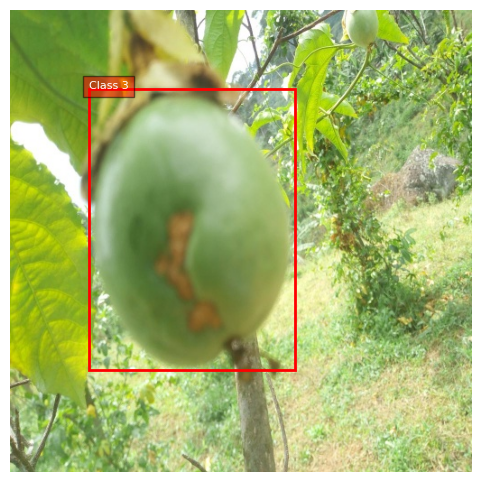

In [13]:
# Example Usage
plot_image(train["Image_ID"].iloc[0], train)

Bounding Boxes for ID_2TW1G4B1:
      xmin   ymin   xmax   ymax
299  322.5  306.0  421.0  406.5
300  136.0  252.5  341.0  427.0
301   91.0   22.0  248.5  150.5
302  411.0  369.0  508.5  449.0


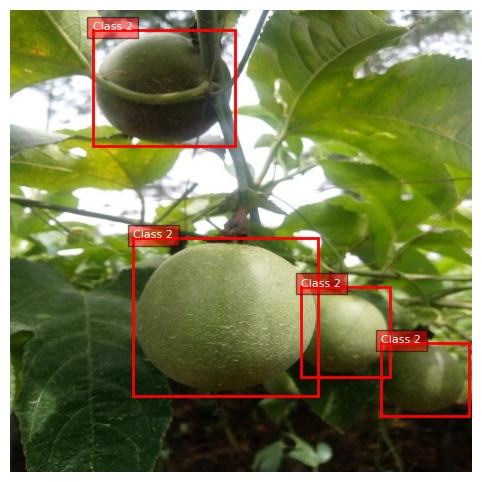

In [14]:

plot_image(train["Image_ID"].iloc[300], train)

Bounding Boxes for ID_00G8K1V3:
   xmin  ymin   xmax   ymax
1  97.5  17.5  342.5  372.0


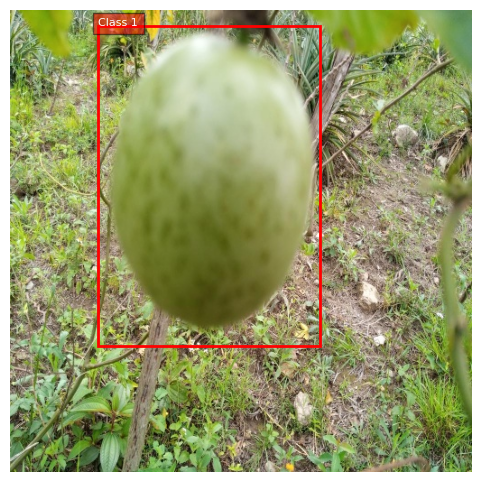

In [15]:
plot_image(train["Image_ID"].iloc[1], train)

#### Converting  data to PyTorch tensors for compatibility with object detection models.

In [18]:
class CustomObjectDetectionDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform
        self.image_ids = dataframe["Image_ID"].unique()
        # Create a mapping from Image_ID to a continuous index
        self.image_id_to_index = {image_id: idx for idx, image_id in enumerate(self.image_ids)}

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_path = os.path.join(self.image_dir, image_id + ".jpg")
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.astype(np.float32) / 255.0  # Normalize image

        # Get bounding boxes and labels
        records = self.dataframe[self.dataframe["Image_ID"] == image_id]
        boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values
        labels = records["class"].values.astype(np.int64)

        # Compute area for each bounding box
        areas = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])  # (width × height)

        # Convert to lists (required by Albumentations)
        boxes = boxes.tolist()
        labels = labels.tolist()
        areas = areas.tolist()

        # Use the index from the mapping as the image_id
        target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64),
            "image_id": torch.tensor([self.image_id_to_index[image_id]], dtype=torch.int64),  # Use index from the mapping
            "area": torch.tensor(areas, dtype=torch.float32),  # Add area field
            "iscrowd": torch.zeros((len(boxes),), dtype=torch.int64)  # Default to 0 (not crowd)
        }

        # Apply transformations
        if self.transform:
            transformed = self.transform(image=image, bboxes=boxes, labels=labels)
            image = transformed["image"]
            target["boxes"] = torch.tensor(transformed["bboxes"], dtype=torch.float32)

        # Convert image to PyTorch tensor
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)

        return image, target

In [19]:
#Example 1
dataset = CustomObjectDetectionDataset(train, IMAGE_DIR)
image, target = dataset[0]
print(image.shape, target)

torch.Size([3, 512, 512]) {'boxes': tensor([[ 87.0000,  87.5000, 315.0000, 398.5000]]), 'labels': tensor([3]), 'image_id': tensor([0]), 'area': tensor([70908.]), 'iscrowd': tensor([0])}


In [20]:
#Example 2
dataset = CustomObjectDetectionDataset(train, IMAGE_DIR)
image, target = dataset[300]
print(image.shape, target)

torch.Size([3, 512, 512]) {'boxes': tensor([[ 65.5000, 124.0000, 399.5000, 407.5000]]), 'labels': tensor([2]), 'image_id': tensor([300]), 'area': tensor([94689.]), 'iscrowd': tensor([0])}


### Augmentations

In [21]:
import albumentations as A

# Define augmentation pipeline
augmentations = A.Compose([
    A.RandomSizedBBoxSafeCrop(512, 512, erosion_rate=0.0, interpolation=1, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.OneOf([
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1.0),
        A.RandomGamma(gamma_limit=(80, 120), p=1.0)
    ], p=1.0),
    A.CLAHE(p=1.0)
], p=1.0, bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

def apply_augmentation(image_path, bboxes, category_ids):
    """Applies augmentation and visualizes the original & transformed images."""

    # Load image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

    # Convert labels to list
    category_ids = [int(label) for label in category_ids]


    # Apply augmentations
    augmented = augmentations(image=image, bboxes=bboxes, labels=category_ids)
    image_aug = augmented["image"]
    bboxes_aug = augmented["bboxes"]

    print("Original BBoxes:", bboxes)
    print("Augmented BBoxes:", bboxes_aug)

    # Plot original & augmented images
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    def plot_image(ax, img, boxes, title):
        ax.imshow(img)
        ax.set_title(title)
        for bbox in boxes:
            rect = patches.Rectangle(
                (bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],
                linewidth=2, edgecolor='r', facecolor='none'
            )
            ax.add_patch(rect)
        ax.axis("off")

    plot_image(axs[0], image, bboxes, "Original Image")
    plot_image(axs[1], image_aug, bboxes_aug, "Augmented Image")

    plt.show()




Original BBoxes: [[322.5, 306.0, 421.0, 406.5], [136.0, 252.5, 341.0, 427.0], [91.0, 22.0, 248.5, 150.5], [411.0, 369.0, 508.5, 449.0]]
Augmented BBoxes: [[100.5916114790287, 308.42147117296224, 211.9205298013245, 410.7196819085487], [191.01103752759383, 253.96421471172962, 422.71081677704194, 431.5864811133201], [295.5584988962472, 19.339960238568587, 473.57174392935985, 150.13916500994037], [1.6953642384106047, 372.5487077534791, 111.89403973509934, 453.98011928429423]]


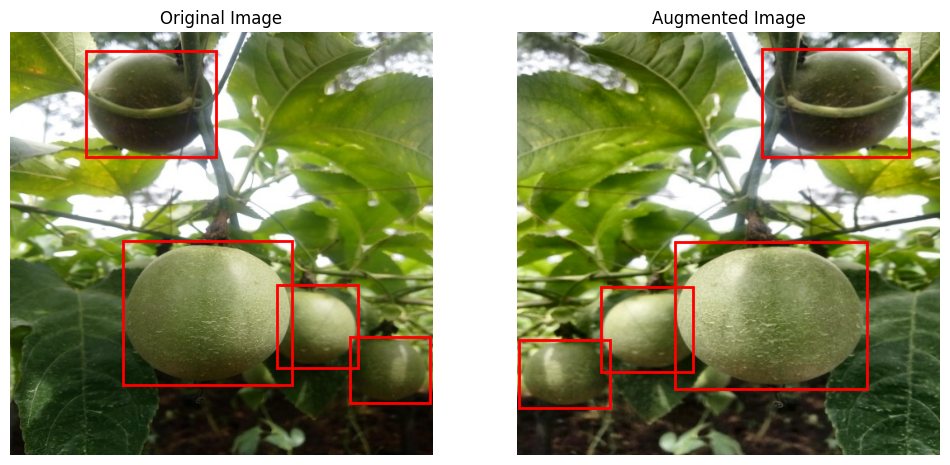

In [22]:
image_id = "ID_2TW1G4B1"  # Select an Image_ID dynamically
image_path = IMAGE_DIR + "/" + image_id + ".jpg"

# Extract bounding boxes & class labels
image_values = train[train["Image_ID"] == image_id]
bboxes = image_values[['xmin', 'ymin', 'xmax', 'ymax']].values.tolist()
category_ids = image_values["class"].tolist()

# Apply augmentation
apply_augmentation(image_path, bboxes, category_ids)



- The Augmentations worked very well even on multiple images  

## Modelling

In [23]:
!pip install pycocotools --quiet
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

Cloning into 'vision'...
remote: Enumerating objects: 610159, done.
remote: Counting objects: 100% (828/828), done.
remote: Compressing objects: 100% (761/761), done.
remote: Total 610159 (delta 707), reused 117 (delta 61), pack-reused 609331 (from 2)
Receiving objects: 100% (610159/610159), 1.14 GiB | 17.20 MiB/s, done.
Resolving deltas: 100% (570564/570564), done.
fatal: not a git repository (or any of the parent directories): .git


In [24]:
train.head()

Image_ID  class   xmin   ymin   xmax   ymax
0  ID_007FAIEI      3   87.0   87.5  315.0  398.5
1  ID_00G8K1V3      1   97.5   17.5  342.5  372.0
2  ID_00WROUT9      1  156.5  209.5  404.5  512.0
3  ID_00ZJEEK3      2  125.0  193.0  379.5  410.0
4  ID_018UIENR      1   79.5  232.5  313.0  414.5

In [25]:
from sklearn.model_selection import train_test_split


df = train.copy()

# Split into training and validation sets (80% train, 20% validation)
train_df, validation_df = train_test_split(df, test_size=0.2, stratify=df["class"], random_state=42)

# Reset indices after splitting
train_df = train_df.reset_index(drop=True)
validation_df = validation_df.reset_index(drop=True)

# Print dataset sizes
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(validation_df)}")


Training set size: 3124
Validation set size: 782


In [26]:
# Transformations for validation (NO augmentations)
val_transform = A.Compose([
    A.Resize(512, 512),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))


In [27]:
from torch.utils.data import DataLoader

# Create dataset objects
train_dataset = CustomObjectDetectionDataset(train_df, IMAGE_DIR, transform=augmentations)
val_dataset = CustomObjectDetectionDataset(validation_df, IMAGE_DIR, transform=val_transform)# No augmentation for validation

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# Check DataLoader output
sample_image, sample_target = next(iter(train_loader))
print(f"Sample image shape: {sample_image[0].shape}")
print(f"Sample target: {sample_target[0]}")


Sample image shape: torch.Size([3, 512, 512])
Sample target: {'boxes': tensor([[ 31.3846,  88.4648, 341.5385, 422.7523]]), 'labels': tensor([1]), 'image_id': tensor([1231]), 'area': tensor([53802.]), 'iscrowd': tensor([0])}


In [28]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Define number of classes (including background)
NUM_CLASSES = len(train_df["class"].unique()) + 1  # Add 1 for background

# Load the pre-trained Faster R-CNN model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Modify the classifier head
in_features = model.roi_heads.box_predictor.cls_score.in_features  # Get input features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES)  # Replace head

# Move model to GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)



Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 155MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [29]:
print("Train Image IDs:", train_dataset.image_ids[:10])
print("Val Image IDs:", val_dataset.image_ids[:10])


Train Image IDs: ['ID_35QEDG07' 'ID_VL5LP2E8' 'ID_CO4RSURQ' 'ID_4OQ7F7PC' 'ID_9JNXXBZH'
 'ID_MZ1LNEY2' 'ID_7J9U3BM3' 'ID_1CEUOSGT' 'ID_BODTC803' 'ID_IPC98JYB']
Val Image IDs: ['ID_OBPR9JSU' 'ID_92RI9E3K' 'ID_QFMU5UCQ' 'ID_HKY65IY5' 'ID_MWIKDNA9'
 'ID_L5PXX2K4' 'ID_VQJ22IF3' 'ID_4VSZ97EK' 'ID_4P9HGM1S' 'ID_41JC26F6']


In [30]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [31]:
from torchmetrics.detection import MeanAveragePrecision
from engine import train_one_epoch  # Removed unused 'evaluate' import
import torch

num_epochs = 5  # Number of training epochs (5 due to computation time)
best_epoch = 0  # Track the epoch with the best performance
best_map = 0.0  # Track the highest mean Average Precision (mAP)

# Initialize mAP metric
map_metric = MeanAveragePrecision()

def evaluate_model(model, data_loader, device, metric):
    model.eval()
    metric.reset()  # Reset metric before evaluation
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, targets in data_loader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            # Convert outputs to the expected format
            for output, target in zip(outputs, targets):
                pred = {
                    "boxes": output["boxes"].detach().cpu(),
                    "scores": output["scores"].detach().cpu(),
                    "labels": output["labels"].detach().cpu(),
                }
                gt = {
                    "boxes": target["boxes"].detach().cpu(),
                    "labels": target["labels"].detach().cpu(),
                }
                all_preds.append(pred)
                all_targets.append(gt)

    # Compute mAP
    map_score = metric(all_preds, all_targets)
    return map_score

# Training Loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs} -----------------------------")

    # Train the model for one epoch
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=50)

    # Update the learning rate scheduler
    lr_scheduler.step()

    # Evaluate the model on the validation set
    map_results = evaluate_model(model, val_loader, device, map_metric)
    print("Mean Average Precision (mAP) Results:", map_results)

    # Save the best model based on mAP
    current_map = map_results["map"].item()

    if current_map > best_map:
        best_map = current_map
        best_epoch = epoch + 1
        torch.save(model.state_dict(), "best_fasterrcnn.pth")
        print(f"Best model saved at epoch {best_epoch} with mAP: {best_map:.4f}")

print("Training and evaluation complete!")
print(f"Best Model was saved from epoch {best_epoch} with mAP: {best_map:.4f}")



Epoch 1/5 -----------------------------
Epoch: [0]  [  0/317]  eta: 0:24:35  lr: 0.000021  loss: 1.2965 (1.2965)  loss_classifier: 1.0840 (1.0840)  loss_box_reg: 0.2056 (0.2056)  loss_objectness: 0.0042 (0.0042)  loss_rpn_box_reg: 0.0026 (0.0026)  time: 4.6551  data: 0.2747  max mem: 7193
Epoch: [0]  [ 50/317]  eta: 0:08:04  lr: 0.000811  loss: 0.3598 (0.5641)  loss_classifier: 0.1466 (0.3443)  loss_box_reg: 0.2014 (0.2122)  loss_objectness: 0.0055 (0.0049)  loss_rpn_box_reg: 0.0022 (0.0027)  time: 1.8152  data: 0.2002  max mem: 7353
Epoch: [0]  [100/317]  eta: 0:06:36  lr: 0.001602  loss: 0.2478 (0.4261)  loss_classifier: 0.0987 (0.2286)  loss_box_reg: 0.1487 (0.1912)  loss_objectness: 0.0014 (0.0039)  loss_rpn_box_reg: 0.0018 (0.0023)  time: 1.8183  data: 0.1836  max mem: 7353
Epoch: [0]  [150/317]  eta: 0:05:05  lr: 0.002392  loss: 0.1401 (0.3466)  loss_classifier: 0.0798 (0.1824)  loss_box_reg: 0.0595 (0.1586)  loss_objectness: 0.0011 (0.0033)  loss_rpn_box_reg: 0.0014 (0.0022)  ti

In [32]:
# Select an image and its corresponding target (ground truth) from the validation dataset
img, target = val_dataset[5]

# Set the model to evaluation mode (disables dropout and batch normalization layers)
model.eval()

# Disable gradient calculation to reduce memory usage and speed up inference
with torch.no_grad():
    # Perform inference on a single image
    prediction = model([img.to(device)])[0]

# Print the number of predicted bounding boxes by the model
print('Predicted # of boxes:', len(prediction['boxes']))

# Print the actual number of ground truth bounding boxes
print('Real # of boxes:', len(target['boxes']))


Predicted # of boxes: 8
Real # of boxes: 1


In [33]:
prediction

{'boxes': tensor([[183.2245, 218.4502, 360.4211, 367.4213],
         [  0.0000, 198.5527,  57.4440, 266.8382],
         [317.0143, 297.8717, 394.2372, 367.1623],
         [214.5039, 265.8401, 392.4677, 367.5675],
         [448.1691,  71.3861, 510.3185, 145.4714],
         [476.4117,  67.4605, 510.9744, 138.1771],
         [475.6388,  67.7436, 512.0000, 140.5076],
         [ 26.2143,   3.5393, 285.6841, 105.4150]], device='cuda:0'),
 'labels': tensor([2, 2, 2, 2, 2, 2, 3, 2], device='cuda:0'),
 'scores': tensor([0.9837, 0.9002, 0.7528, 0.2206, 0.1021, 0.0888, 0.0547, 0.0523],
        device='cuda:0')}

In [34]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_valid(img, prediction, detect_thresh=0.5):
    """
    Function to visualize object detection results.

    Parameters:
    - img: Tensor representing the input image (C, H, W).
    - prediction: Dictionary containing model predictions (boxes, labels, scores).
    - detect_thresh: Float, threshold for displaying detections (default=0.5).
    """

    # Create a figure and axis for visualization
    fig, ax = plt.subplots(figsize=(18, 10))

    # Convert the image tensor (C, H, W) to a NumPy array (H, W, C) for visualization
    val_img = img.permute(1, 2, 0).cpu().numpy()
    ax.imshow(val_img)  # Display the image

    # Extract bounding boxes, labels, and confidence scores from the prediction
    val_scores = prediction['scores'].cpu().detach().numpy()  # Confidence scores
    bbox = prediction['boxes'].cpu().detach().numpy()  # Bounding boxes
    labels = prediction["labels"].cpu().detach().numpy()  # Class labels

    # Iterate over each detected bounding box
    for i in range(len(bbox)):
        if val_scores[i] >= detect_thresh:  # Apply confidence threshold
            box = bbox[i]  # Extract the bounding box coordinates
            x, y, w, h = box[0], box[1], box[2] - box[0], box[3] - box[1]  # Convert to (x, y, width, height)

            # Create a red rectangle patch for the bounding box
            rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)  # Add the rectangle to the plot

            # Add label text above the bounding box
            label_text = f"Class {labels[i]} | Score: {val_scores[i]:.3f}"
            ax.text(x, y, label_text, verticalalignment='top', color='white', fontsize=12, weight='bold', bbox=dict(facecolor='red', alpha=0.5))

    # Display the final visualization
    plt.show()


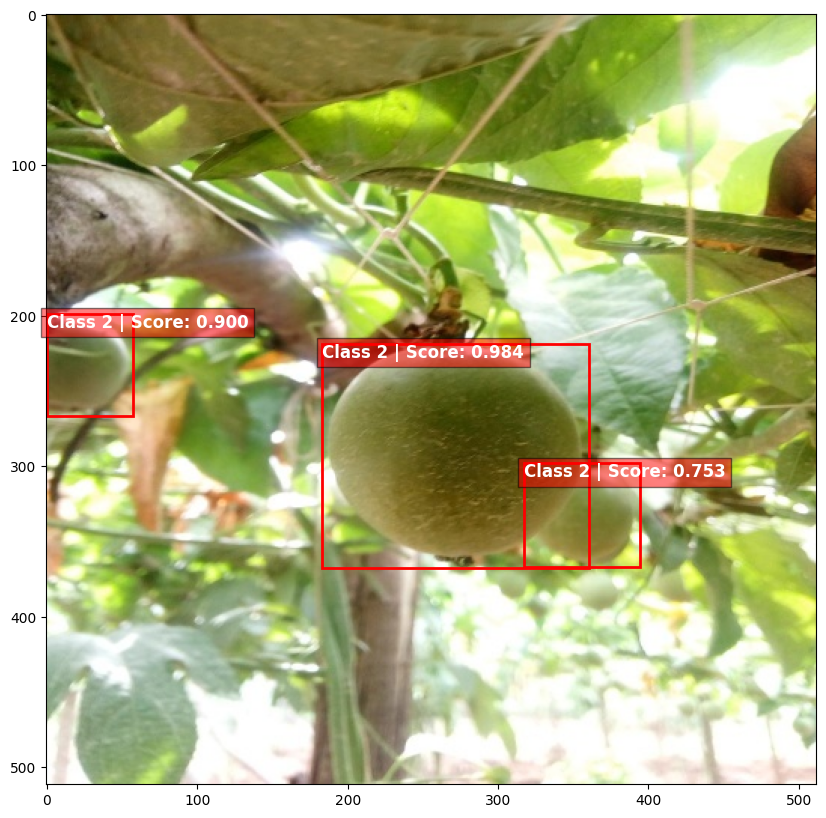

In [35]:
plot_valid(img,prediction)

### Loading and predicting the test data

In [40]:
TEST_IMG_DIR = "/content/Test_Images"

In [36]:
import os
import cv2
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2

class TestDataset(Dataset):
    def __init__(self, df, TEST_IMG_DIR, transforms):
        """
        Custom Dataset for handling test images.

        Args:
            df (pd.DataFrame): DataFrame containing image IDs.
            IMG_DIR (str): Directory where test images are stored.
            transforms (albumentations.Compose, optional): Transformations to apply to the images.
        """
        self.df = df
        self.img_dir = TEST_IMG_DIR
        self.transforms = transforms
        self.image_ids = self.df["Image_ID"].tolist()  # List of image IDs

    def __len__(self):
        """Returns the total number of images."""
        return len(self.image_ids)

    def __getitem__(self, idx):
        """Loads and transforms an image by index."""
        image_id = self.image_ids[idx]

        # Load image
        image_path = os.path.join(self.img_dir, image_id + ".jpg")
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)  # Convert BGR to RGB

        # Apply transformations if available
        if self.transforms:
            sample = {"image": image}
            sample = self.transforms(**sample)
            image = sample["image"]

        return image, image_id




In [37]:
import cv2
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2

class One_Image:
    def __init__(self, IMG_PATH, transforms):
        """
        Handles a single image for preprocessing.

        Args:
            IMG_PATH (str): Path to the image file.
            transforms (albumentations.Compose, optional): Transformations to apply.
        """
        self.img_path = IMG_PATH
        self.transforms = transforms

    def __getitem__(self, idx=0):
        """
        Loads and preprocesses a single image.

        Args:
            idx (int, optional): Unused, but added for compatibility with dataset indexing.

        Returns:
            torch.Tensor: Preprocessed image tensor.
        """
        # Load image from path
        image = cv2.imread(self.img_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)  # Convert BGR to RGB

        # Apply transformations if provided
        if self.transforms:
            sample = {"image": image}
            sample = self.transforms(**sample)
            image = sample["image"]

        return image




In [38]:
# Define test transformations
def get_test_transform(IMG_SIZE=(512, 512)):
    return A.Compose([
        A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1.0),
        A.Resize(*IMG_SIZE),
        ToTensorV2(p=1.0),
    ])

In [41]:

# Define the same model structure as used in training
def load_model(model_path, num_classes, device):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)

    # Modify the classifier to match the number of classes
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Load trained weights
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    return model

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 4  # Adjust based on your dataset (1 class + background)
model = load_model("best_fasterrcnn.pth", num_classes, device)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 184MB/s]


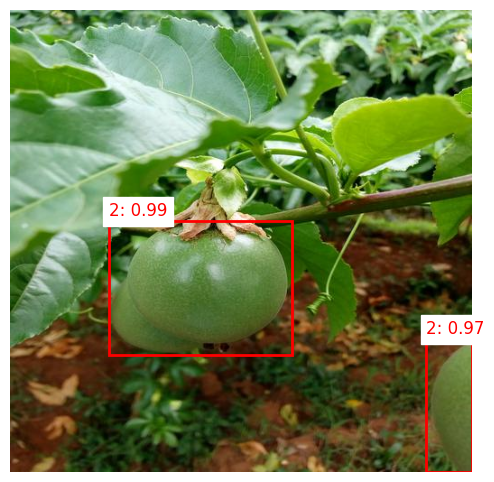

In [45]:
import matplotlib.pyplot as plt
import cv2
import torch

# Choose a test image path
test_image_id = "ID_ZPNDRD4T"  # Select an Image_ID dynamically
test_image_path = TEST_IMG_DIR + "/" + test_image_id + ".jpg"


# Apply transformations using One_Image class
one_image = One_Image(test_image_path, get_test_transform())
image_tensor = one_image[0].unsqueeze(0).to(device)  # Add batch dimension and move to device

# Set model to evaluation mode and make predictions
model.eval()
with torch.no_grad():
    prediction = model(image_tensor)[0]

# Load original image for visualization
image = cv2.imread(test_image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Plot the image and draw bounding boxes
plt.figure(figsize=(8, 6))
plt.imshow(image)

# Extract predicted boxes, labels, and scores
boxes = prediction["boxes"].cpu().numpy()
scores = prediction["scores"].cpu().numpy()
labels = prediction["labels"].cpu().numpy()

# Draw only boxes with confidence > 0.5
for box, score, label in zip(boxes, scores, labels):
    if score > 0.5:
        x1, y1, x2, y2 = box.astype(int)
        plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor="red", linewidth=2))
        plt.text(x1, y1 - 5, f"{label}: {score:.2f}", color="red", fontsize=12, backgroundcolor="white")

plt.axis("off")
plt.show()


In [46]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader

# Define test image directory and CSV file with image IDs
TEST_IMG_DIR = "/content/Test_Images"
TEST_CSV = "/content/Test.csv"

# Load test image IDs from a CSV file
df_test = pd.read_csv(TEST_CSV)

# Create test dataset and data loader
test_dataset = TestDataset(df_test, TEST_IMG_DIR, get_test_transform())
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Function for Non-Maximum Suppression (NMS) - you should define nms_bbox function
def nms_bbox(boxes, scores, iou_threshold=0.5):
    """
    Applies Non-Maximum Suppression (NMS) to filter out redundant bounding boxes.

    Args:
        boxes (numpy.ndarray): Array of bounding boxes [x1, y1, x2, y2].
        scores (numpy.ndarray): Array of confidence scores.
        iou_threshold (float): IOU threshold for NMS.

    Returns:
        List of indices of selected bounding boxes.
    """
    import torchvision.ops as ops
    boxes_tensor = torch.tensor(boxes, dtype=torch.float32)
    scores_tensor = torch.tensor(scores, dtype=torch.float32)
    keep = ops.nms(boxes_tensor, scores_tensor, iou_threshold)
    return keep.tolist()

# Initialize a list to store prediction results
results = []

# Set model to evaluation mode
model.eval()

# Perform inference on the test dataset
with torch.no_grad():
    for images, image_ids in test_loader:
        images = [img.to(device) for img in images]  # Move images to the correct device
        predictions = model(images)  # Get model predictions

        for i in range(len(predictions)):
            image_id = image_ids[i]  # Get image ID
            pred = predictions[i]  # Get predictions for the current image

            # Extract bounding boxes, labels, and confidence scores
            boxes = np.array(pred["boxes"].cpu().tolist())
            labels = pred["labels"].cpu().tolist()
            scores = np.array(pred["scores"].cpu().tolist())

            # Apply Non-Maximum Suppression (NMS) to filter overlapping boxes
            if len(boxes) > 0:
                keep = nms_bbox(boxes, scores)
                boxes = boxes[keep]
                labels = [labels[j] for j in keep]
                scores = scores[keep]

            # Store results in a structured format
            for b, l, s in zip(boxes, labels, scores):
                results.append({
                    "Image_ID": image_id,
                    "boxes": b.tolist(),  # Convert NumPy array to list
                    "labels": l,
                    "confidence": s
                })

# Convert results list to a DataFrame
sub_df = pd.DataFrame(results)

# Display the DataFrame
sub_df.head()



Image_ID                                              boxes  labels  \
0  ID_IUJJG62B  [73.49131774902344, 142.93280029296875, 377.40...       2   
1  ID_IUJJG62B  [282.7137756347656, 316.5447082519531, 476.398...       2   
2  ID_IUJJG62B  [435.7619934082031, 403.3255920410156, 510.535...       2   
3  ID_ZPNDRD4T  [109.56230926513672, 233.58282470703125, 312.4...       2   
4  ID_ZPNDRD4T  [461.7283020019531, 364.13311767578125, 511.11...       2   

   confidence  
0    0.997282  
1    0.975628  
2    0.737446  
3    0.991810  
4    0.966945

In [50]:
# Define test image directory and CSV file with image IDs
TEST_IMG_DIR = "/content/Test_Images"
TEST_CSV = "/content/Test.csv"

# Load test image IDs from a CSV file
df_test = pd.read_csv(TEST_CSV)

# Create test dataset and data loader
test_dataset = TestDataset(df_test, TEST_IMG_DIR, get_test_transform())
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Function for Non-Maximum Suppression (NMS)
def nms_bbox(boxes, scores, iou_threshold=0.5):
    import torchvision.ops as ops
    boxes_tensor = torch.tensor(boxes, dtype=torch.float32)
    scores_tensor = torch.tensor(scores, dtype=torch.float32)
    keep = ops.nms(boxes_tensor, scores_tensor, iou_threshold)
    return keep.tolist()

# Initialize a list to store prediction results
results = []

# Set model to evaluation mode
model.eval()

# Perform inference on the test dataset
with torch.no_grad():
    for images, image_ids in test_loader:
        images = [img.to(device) for img in images]  # Move images to the correct device
        predictions = model(images)  # Get model predictions

        for i in range(len(predictions)):
            image_id = image_ids[i]  # Get image ID
            pred = predictions[i]  # Get predictions for the current image

            # Extract bounding boxes, labels, and confidence scores
            boxes = np.array(pred["boxes"].cpu().tolist())
            labels = pred["labels"].cpu().tolist()
            scores = np.array(pred["scores"].cpu().tolist())

            # Apply Non-Maximum Suppression (NMS)
            if len(boxes) > 0:
                keep = nms_bbox(boxes, scores)
                boxes = boxes[keep]
                labels = [labels[j] for j in keep]
                scores = scores[keep]

            # Store results in a structured format
            for b, l, s in zip(boxes, labels, scores):
                xmin, ymin, xmax, ymax = b  # Extract bounding box coordinates
                results.append({
                    "Image_ID": image_id,
                    "xmin": xmin,
                    "ymin": ymin,
                    "xmax": xmax,
                    "ymax": ymax,
                    "labels": l,
                    "confidence": s
                })

# Convert results list to a DataFrame
sub_df = pd.DataFrame(results)

# Display the DataFrame
print(sub_df.head())

      Image_ID        xmin        ymin        xmax        ymax  labels  \
0  ID_IUJJG62B   73.491318  142.932800  377.402466  398.584717       2   
1  ID_IUJJG62B  282.713776  316.544708  476.398529  476.288971       2   
2  ID_IUJJG62B  435.761993  403.325592  510.535034  485.057220       2   
3  ID_ZPNDRD4T  109.562309  233.582825  312.492462  382.523285       2   
4  ID_ZPNDRD4T  461.728302  364.133118  511.111969  512.000000       2   

   confidence  
0    0.997282  
1    0.975628  
2    0.737446  
3    0.991810  
4    0.966945  


In [51]:
classes_la = {0:"Background", 1:"fruit_brownspot", 2:"fruit_healthy", 3:"fruit_woodiness"}
sub_df["labels"] = sub_df["labels"].apply(lambda x: classes_la[x])

In [52]:
sub_df.rename(columns={"labels":"class"}, inplace=True)


In [53]:
sub_df.head()

Image_ID        xmin        ymin        xmax        ymax          class  \
0  ID_IUJJG62B   73.491318  142.932800  377.402466  398.584717  fruit_healthy   
1  ID_IUJJG62B  282.713776  316.544708  476.398529  476.288971  fruit_healthy   
2  ID_IUJJG62B  435.761993  403.325592  510.535034  485.057220  fruit_healthy   
3  ID_ZPNDRD4T  109.562309  233.582825  312.492462  382.523285  fruit_healthy   
4  ID_ZPNDRD4T  461.728302  364.133118  511.111969  512.000000  fruit_healthy   

   confidence  
0    0.997282  
1    0.975628  
2    0.737446  
3    0.991810  
4    0.966945

In [54]:
submission = pd.DataFrame(sub_df, columns=["Image_ID",	"class",	"confidence",	"ymin",	"xmin",	"ymax",	"xmax"])

In [55]:
submission.head()

Image_ID          class  confidence        ymin        xmin        ymax  \
0  ID_IUJJG62B  fruit_healthy    0.997282  142.932800   73.491318  398.584717   
1  ID_IUJJG62B  fruit_healthy    0.975628  316.544708  282.713776  476.288971   
2  ID_IUJJG62B  fruit_healthy    0.737446  403.325592  435.761993  485.057220   
3  ID_ZPNDRD4T  fruit_healthy    0.991810  233.582825  109.562309  382.523285   
4  ID_ZPNDRD4T  fruit_healthy    0.966945  364.133118  461.728302  512.000000   

         xmax  
0  377.402466  
1  476.398529  
2  510.535034  
3  312.492462  
4  511.111969

In [56]:
submission.to_csv("submission.csv", index=False)